<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Age-Detection-Actors-Challenges" data-toc-modified-id="Age-Detection-Actors-Challenges-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Age Detection Actors Challenges</a></span><ul class="toc-item"><li><span><a href="#Getting-Started" data-toc-modified-id="Getting-Started-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Getting Started</a></span></li><li><span><a href="#Data-description" data-toc-modified-id="Data-description-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data description</a></span></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data preprocessing</a></span><ul class="toc-item"><li><span><a href="#KMeans-algorithm" data-toc-modified-id="KMeans-algorithm-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>KMeans algorithm</a></span></li><li><span><a href="#Filters" data-toc-modified-id="Filters-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Filters</a></span></li></ul></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Data Augmentation</a></span></li><li><span><a href="#Varational-Auto-Encoder-(VAE)" data-toc-modified-id="Varational-Auto-Encoder-(VAE)-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Varational Auto-Encoder (VAE)</a></span></li></ul></li></ul></div>

# Age Detection Actors Challenges

The present notebook presents a solution to the challenge entitled: [Age Detection of Actors](https://datahack.analyticsvidhya.com/contest/practice-problem-age-detection). The purpose is to detect the age group of Indian actors from a sample of data extracted from the [IMFDB database](http://cvit.iiit.ac.in/projects/IMFDB/). Each image presents different variations in size, pose, expression, illumination, age, resolution, occlusion, and makeup. Thus, dealing with such a varied population of images is a challenge. For more information see the challenge page at the [link](https://datahack.analyticsvidhya.com/contest/practice-problem-age-detection).

We create a repository with different libraries needed to run the following notebook, as well as store the database and the results. The repository is named [#Age-Detection-Actors-Challenge](https://github.com/daca1897/Age-Detection-Actors-Challenge).

## Getting Started

First, you need download the repository, unzip the data contains in `./data` folder and install the requerements. All the information is saved in [readme](https://github.com/daca1897/Age-Detection-Actors-Challenge/blob/main/README.md). Then, we can start to import the libraries.

In [1]:
# Libraries
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1MB 9.1MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-cp37-none-any.whl size=2115442 sha256=ba4d61abfe7b4d8de69796b6852ec7f7223587bf91cfb11c8338313a6c2dbb6b
  Stored in directory: /root/.cache/pip/wheels/af/dc/2a/5c3633135e7e4ef4fd31463cfa1942cb1bae7486ab94e7a2ad
Successfully built mitdeeplearning


If you are working in colab, you need add the path where the repo was downloaded to `cwd_list`. 

In [2]:
# Colab access
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install -r requerements.txt
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/gdrive')

# If you work-directory don't match, please add the new path to pwd_list
cwd_list = ["/content/gdrive/MyDrive/IMT Atlantique/Project_S5_Air/Age-Detection-Actors-Challenge/",
            "/content/gdrive/MyDrive/IMT Atlantique/FouilleDonnéesAvancée/Age-Detection-Actors-Challenge/",            
            os.path.join(os.getcwd(),"Age-Detection-Actors-Challenge"),
            os.getcwd()]

for cwd in cwd_list:
    if os.path.isdir(cwd):
        %cd "$cwd"
        break
if os.path.split(os.getcwd())[-1] != "Age-Detection-Actors-Challenge":
    print("[WARNING]: Incorrect working directory. Please add the fix-directory to the cwd_list.")
else: 
    print("[INFO]: Work directory: " + os.getcwd())
    
sys.path.append('./libraries')
sys.path.append('./examples')

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requerements.txt'
Mounted at /content/gdrive
/content/gdrive/MyDrive/IMT Atlantique/FouilleDonnéesAvancée/Age-Detection-Actors-Challenge
[INFO]: Work directory: /content/gdrive/MyDrive/IMT Atlantique/FouilleDonnéesAvancée/Age-Detection-Actors-Challenge


In [ ]:
from libraries.preprocessing import Preprocessing
from libraries.preprocessing import image_plot, images_plot
import kmeans
print("[INFO] Libraries and repository install successfully.")

[INFO] Libraries and repository install successfully.


Now, we can start with data processing

## Data description

In challenge, we have a total of 26742 images with 19906 images in train and 6636 images in test. Each image train is labeled with {YOUNG, MIDDLE, OLD} class. To begin with, we will start by showing some random images, and explain the different treatments performed. 

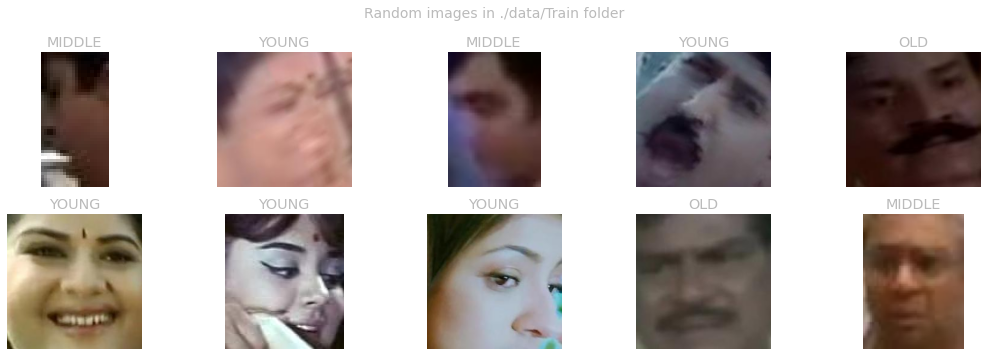

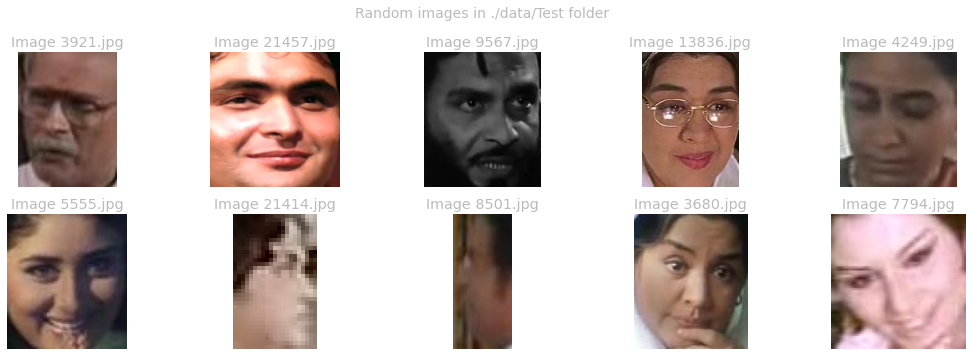

In [ ]:
def images_dir_plot(dir_path, csv_file = None, nrows = 2, ncols = 5):
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (15, 5))
    fig.suptitle("Random images in {} folder".format(dir_path), fontsize=14)
    image_list = [os.path.join(dir_path, x) for x in os.listdir(dir_path)]
    iind = np.random.randint(0, len(image_list), size = nrows*ncols)
    if csv_file is not None: 
        csv_file = pd.read_csv(csv_file, header = 0).set_index('ID')
    for i, ax in enumerate(axs.reshape(-1)):
        image = cv2.cvtColor(cv2.imread(image_list[iind[i]]), cv2.COLOR_BGR2RGB)
        if csv_file is None or 'Class' not in csv_file.columns:
            ax.set_title("Image " + image_list[iind[i]].split(os.sep)[-1])
        else:
            ax.set_title(csv_file.loc[image_list[iind[i]].split(os.sep)[-1], 'Class'])
        ax.imshow(image)
        ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

images_dir_plot('./data/Train', './data/Train_Augmented.csv')
images_dir_plot('./data/Test', './data/test.csv')

If we run the above code several times we will see that there are different variations in size, pose, expression, illumination, age, resolution, occlusion, makeup and image format (gray, color scales). To try to handle these problems a little, we will perform a preprocessing phase.

## Data preprocessing

In digital image processing (DIP) there are multiple filters that allow (for example) rescaling, illumination correction and conversion of images from black and white to color. The objective of the preprocessing will then be to make some corrections, such as:
* size and resolution problems  with the unification of a standard size,
* ilumination and makeup problems with automatic brightness adjustment,
* image format problem with standardization and normalization of a single format (color (by default) or gray), and
* pose problem with data augmentation.

These filters are expected to improve the processing of the data, so that the solution model (presented later) will find more characteristics with respect to the age of the people (purpose of the project).

For processing, we created a library that allows us to perform the first two steps in solution items. But first, we must mainly define the size to which we want to resize all the images in order to standardize.

### KMeans algorithm

With the multiplicity of sizes we have, inspired by the [YOLO](https://pjreddie.com/darknet/yolo/) bounding boxes definition, we decided to implement an unsupervised algorithm that determines the ideal size to which we should resize the images. As an unsupervised algorithm we use KMeans, whose input would be the height and width characteristics of all images in logarithmic scale. We created a program to execute the kmeans in train-test data. The results are shown below.

  0%|          | 45/31990 [00:00<01:11, 445.81it/s]

[INFO] Reading images from ./data/Train


  1%|          | 48/6636 [00:00<00:13, 476.24it/s]

[INFO] Reading images from ./data/Test


100%|██████████| 6636/6636 [00:10<00:00, 605.35it/s]
0it [00:00, ?it/s]

[INFO] KMeans process...


10it [01:58, 11.82s/it]



[INFO]: NC#1 -> mean(max(IoU)) = 0.3449679257159094
[INFO]: NC#2 -> mean(max(IoU)) = 0.6116247466474521
[INFO]: NC#3 -> mean(max(IoU)) = 0.7263857247141668
[INFO]: NC#4 -> mean(max(IoU)) = 0.7726236227976068
[INFO]: NC#5 -> mean(max(IoU)) = 0.7946988993787067
[INFO]: NC#6 -> mean(max(IoU)) = 0.81665867623609
[INFO]: NC#7 -> mean(max(IoU)) = 0.8354247507070572
[INFO]: NC#8 -> mean(max(IoU)) = 0.8482545423582059
[INFO]: NC#9 -> mean(max(IoU)) = 0.857411136939691
[INFO]: NC#10 -> mean(max(IoU)) = 0.8651145905062075
[INFO]: Cluster's center:  {1: array([[106.45301143, 127.70687093]]), 2: array([[ 45.96039583,  61.73329149],
       [188.33416045, 209.24181986]]), 3: array([[214.28353091, 230.77968404],
       [ 34.20814058,  46.82024096],
       [ 82.80358972, 107.07458996]]), 4: array([[107.44827683, 136.98045691],
       [ 28.83553527,  39.59284651],
       [222.98363414, 236.6135786 ],
       [ 56.40232571,  75.17475827]]), 5: array([[121.25815663, 154.01213816],
       [ 24.96888175,  

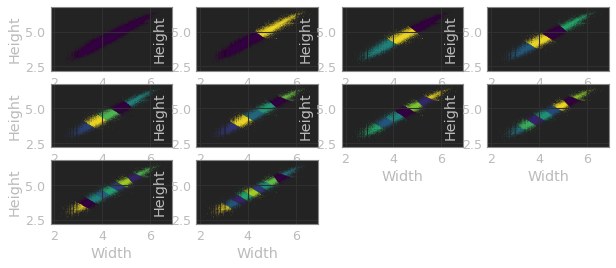

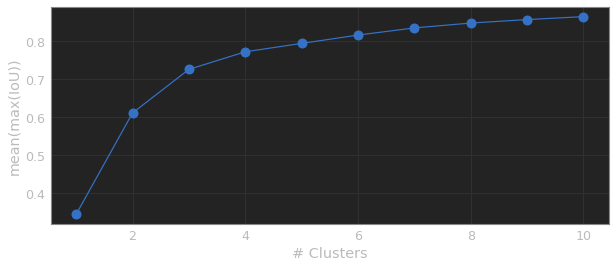

In [ ]:
kmeans.kmeans_process()

As a performance measure we use `mean(max(IOU))`. It is clear that the higher the number of clusters, the higher the performance measure will be. However, since we must limit ourselves to a single resizing value, we will choose the values corresponding to a single cluster. For the unincreased data it should correspond to a width, height = (80,100). For the augmented data (see below), the measures are width, height = (106,128).

### Filters

As mentioned, we will use the library created to display the filters. For information on how to use the library, see [#Age-Detection-Actors-Challenge](https://github.com/daca1897/Age-Detection-Actors-Challenge). 

Let's start with resize approach:

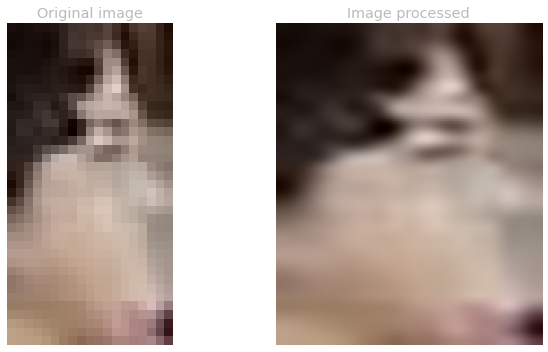

In [ ]:
random_image = np.random.choice(os.listdir('./data/Train'), 1)

preproc = Preprocessing(resize = (106,128), normalize = False)
image = preproc.image_read(os.path.join('./data/Train', random_image[0]), process = False)
image_proc = preproc.image_read(os.path.join('./data/Train', random_image[0]), process = True)

image_plot(image, image_proc)

Now, we will see the different gray-color scales:

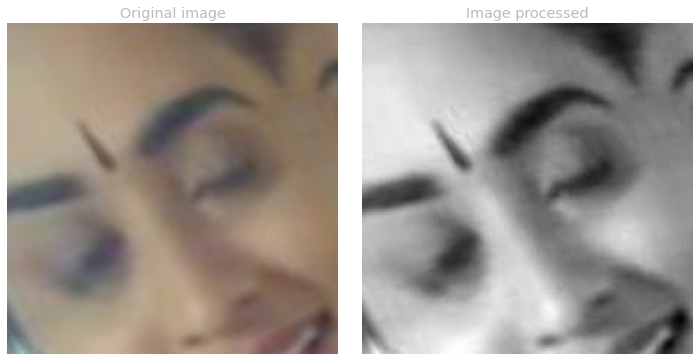

In [ ]:
random_image = np.random.choice(os.listdir('./data/Train'), 1)

preproc = Preprocessing(gray_scale = True, normalize = False)
image = preproc.image_read(os.path.join('./data/Train', random_image[0]), process = False)
image_proc = preproc.image_read(os.path.join('./data/Train', random_image[0]), process = True)

image_plot(image, image_proc)

Finally, the illumination correction is shown below:

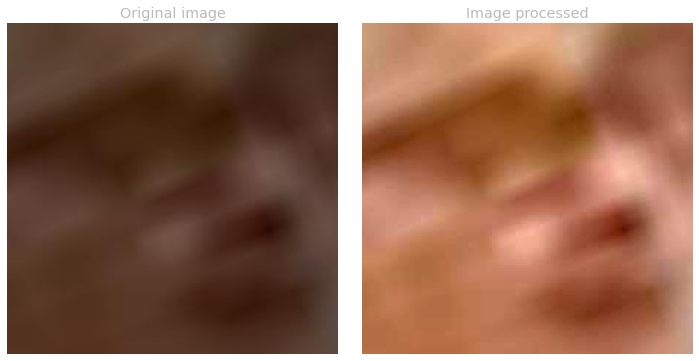

In [ ]:
random_image = np.random.choice(os.listdir('./data/Train'), 1)

preproc = Preprocessing(normalize = True)
image = preproc.image_read(os.path.join('./data/Train', random_image[0]), process = False)
image_proc = preproc.image_read(os.path.join('./data/Train', random_image[0]), process = True)

image_plot(image, image_proc)

If we join all the filters together and preview some images, we will obtain the following results:

  3%|▎         | 32/1000 [00:00<00:03, 313.79it/s]

[INFO] Preprocessing in gray scale: 
[INFO] Reading images...


100%|██████████| 1000/1000 [00:03<00:00, 310.14it/s]


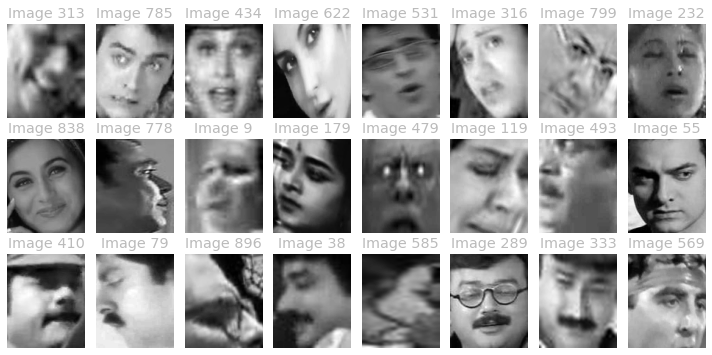

In [ ]:
random_image_list = np.random.choice(os.listdir('./data/Train'), 1000)

print("[INFO] Preprocessing in gray scale: ")
preproc = Preprocessing(normalize = True, gray_scale = True, resize = (106,128))
images_batch = preproc.images_processing([os.path.join('./data/Train', x) for x in random_image_list])
images_plot(images_batch, nrows = 3, ncols = 8)

  3%|▎         | 29/1000 [00:00<00:03, 281.03it/s]

[INFO] Preprocessing in color scale: 
[INFO] Reading images...


100%|██████████| 1000/1000 [00:03<00:00, 264.24it/s]


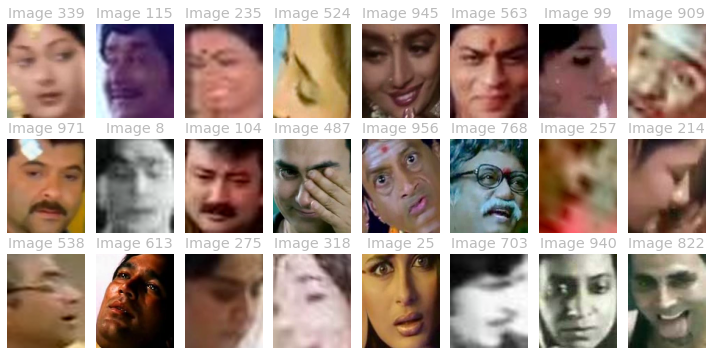

In [ ]:
random_image_list = np.random.choice(os.listdir('./data/Train'), 1000)

print("[INFO] Preprocessing in color scale: ")
preproc.gray_scale = False
images_batch = preproc.images_processing([os.path.join('./data/Train', x) for x in random_image_list])
images_plot(images_batch, nrows = 3, ncols = 8)

Now, to correct some pose and class imbalance problems, we will show a data augmentation process.

## Data Augmentation

## Varational Auto-Encoder (VAE)

Our goal is to train a debiased version of this classifier because we can see unbalance in the data, we built a debiased facial classifier, we'll train a model that learns a representation of the underlying latent space to the face training data. The model then uses this information to mitigate unwanted biases by sampling faces with rare features, like different skin color, hats or glasses,during training.

### Creation dataset

In [5]:
!unrar e './data/color_train_unlabel.rar' '/content/' #unzip the file of faces in temporal dir /content/


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from ./data/color_train_unlabel.rar

Extracting  /content/color_train_unlabel.pkl                               0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%  OK 

In [3]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263894528/1263889489 [==============================] - 46s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [6]:
import pickle
with open('/content/color_train_unlabel.pkl', 'rb') as f:
  imagechallenge = pickle.load(f)

In [7]:
images, labels = loader.images[...,::-1], loader.labels

In [8]:
images = images[np.where(labels == 0)[0]]
labels = labels[np.where(labels== 0)[0]] 

In [9]:
l = len(imagechallenge)
images = np.concatenate([images , imagechallenge], axis = 0)
del imagechallenge
labels = np.concatenate([labels, np.ones((l, 1))], axis = 0)

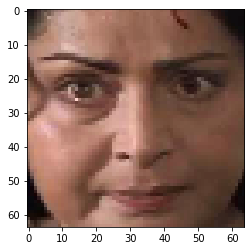

In [10]:
plt.imshow(images[np.where(labels==1)[0]][1])

In [11]:
images.shape, labels.shape

((86947, 64, 64, 3), (86947, 1))

In [12]:
import h5py
def store_many_hdf5(images, labels):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File('/content/kaggle.h5', "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images),  data=images
    )
    meta_set = file.create_dataset(
        "labels", np.shape(labels),  data=labels
    )
    file.close()

In [13]:
store_many_hdf5(images[...,::-1], labels)

### Standard classifier model

In [14]:
loader = mdl.lab2.TrainingDatasetLoader('/content/kaggle.h5')

Opening /content/kaggle.h5
Loading data into memory...


In [15]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

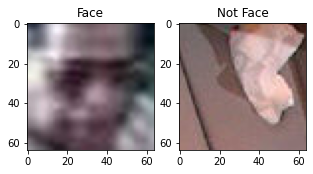

In [16]:
### Examining the CelebA training dataset ###

#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]] 
not_face_images = images[np.where(labels==0)[0]]  

idx_face = 29 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 38 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face]) 
plt.title("Not Face"); plt.grid(False)

We define our CNN model, and then train on the CelebA and ImageNet datasets using the tf.GradientTape class and the tf.GradientTape.gradient method.

In [17]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

Here we trained the standard CNN with the biased information of the data

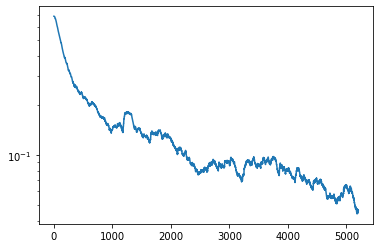

100%|██████████| 2717/2717 [00:25<00:00, 108.08it/s]


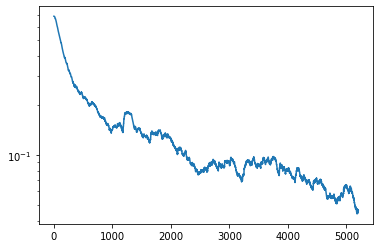

In [18]:
### Train the standard CNN ###

# Training hyperparameters
batch_size = 32
num_epochs = 2  # keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x) 
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

In [19]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 0.9828


Below we define tha function that calculate the VAE loss of the reconstructed image.

In [20]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x, 
      reconstructed output x_recon, 
      encoded means mu, 
      encoded log of standard deviation logsigma, 
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
  # in the text block directly above
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  # latent_loss = # TODO

  # TODO: Define the reconstruction loss as the mean absolute pixel-wise 
  # difference between the input and reconstruction. Hint: you'll need to 
  # use tf.reduce_mean, and supply an axis argument which specifies which 
  # dimensions to reduce over. For example, reconstruction loss needs to average 
  # over the height, width, and channel image dimensions.
  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  # reconstruction_loss = # TODO

  # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
  # in the text block directly above
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  # vae_loss = # TODO
  
  return vae_loss

VAE Reparametrization this will allow us to define the loss function for the VAE, generate randomly sampled latent variables, achieve better network generalization, and make our complete VAE network differentiable so that it can be trained by backpropagation. 

In [21]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # TODO: Define the reparameterization computation!
  # Note the equation is given in the text block immediately above.
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  # z = # TODO
  return z

The idea behind debiasing is to use the latent variables learned through a VAE to adaptively resample the face data during training. The probability of a given image being used during training will be modified based on how often its latent features appear in the dataset. Thus, faces with rarer features (such as dark skin, sunglasses, or hats) should be more likely to be sampled during training.


In [22]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  # TODO: call the relevant function to obtain VAE loss
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  # vae_loss = vae_loss_function('''TODO''') # TODO

  # TODO: define the classification loss using sigmoid_cross_entropy
  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  # classification_loss = # TODO

  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # TODO: define the DB-VAE total loss! Use tf.reduce_mean to average over all
  # samples
  total_loss = tf.reduce_mean(
      classification_loss + 
      face_indicator * vae_loss
  )
  # total_loss = # TODO

  return total_loss, classification_loss

### DB-VAE architecture

Here we define the DB-VAE architecture. To build the DB-VAE, we will use the standard CNN classifier from above as our encoder, and then define a decoder network. We will create and initialize the two models, and then construct the  VAE.

The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers, and output a reconstruction of the original input image.

In [23]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

Now, we will put this decoder together with the standard CNN classifier as our encoder to define the VAE. 

In [24]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean, z_logsigma)
    # z = # TODO
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder to output the reconstruction
    reconstruction = self.decoder(z)
    # reconstruction = # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: reparameterization
    z = self.reparameterize(z_mean, z_logsigma)
    # z = # TODO

    # TODO: reconstruction
    recon = self.decode(z)
    # recon = # TODO
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

### Adaptive resampling for automated debiasing with DB-VAE

For make the debiaisng of a  facial detection classifier, images are fed through the network, the encoder learns an estimate latent space $z$ and then we increase the relative frequency of rare data by increased sampling of under-represented regions of the latent space. We can approximate $z$ using the frequency distributions of each of the learned latent variables, and then define the probability distribution of selecting a given datapoint $x$ based on this approximation. These probability distributions will be used during training to re-sample the data.

The next function returns the latent variable means returned by the encoder after a batch of images is inputted to the network:

In [25]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

 The next function recomputes the sampling probabilities for images within a batch based on how they distribute across the training data.

In [26]:
### Resampling algorithm for DB-VAE ###

'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae)
    # mu = get_latent_mu('''TODO''') # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
        # TODO: call the digitize function to find which bins in the latent distribution 
        #    every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges)
        # bin_idx = np.digitize('''TODO''', '''TODO''') # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function 
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        # TODO: normalize all probabilities
        p = p / np.sum(p)
        # p = # TODO
        
        # TODO: update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(p, training_sample_p)
        # training_sample_p = # TODO
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Here we train the debiased VAE (DB-VAE)

Starting epoch 5/100
Recomputing the sampling probabilities


  0%|          | 0/2717 [00:00<?, ?it/s]

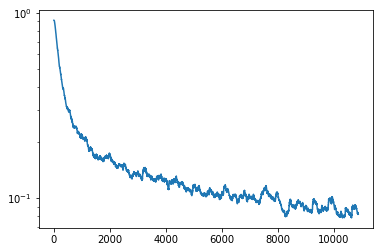

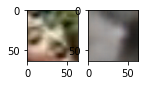

 18%|█▊        | 493/2717 [00:05<00:22, 96.76it/s]

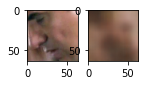

 37%|███▋      | 996/2717 [00:11<00:17, 96.38it/s]

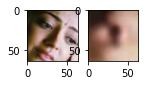

 55%|█████▍    | 1491/2717 [00:16<00:12, 95.78it/s]

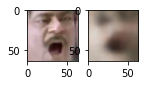

 74%|███████▎  | 2000/2717 [00:22<00:07, 95.69it/s]

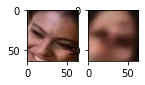

 92%|█████████▏| 2492/2717 [00:27<00:02, 95.79it/s]

KeyboardInterrupt: ignored

 92%|█████████▏| 2492/2717 [00:27<00:02, 89.18it/s]


In [ ]:
### Training the DB-VAE ###

loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
# Hyperparameters
batch_size = 32
learning_rate = 5e-4
#learning_rate = 7e-4
latent_dim = 100

# DB-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 30 

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)
#optimizer = tf.keras.optimizers.SGD(learning_rate)


# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    '''TODO: call the DB_VAE loss function to compute the loss'''
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  
  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the dbvae.'''
  grads = tape.gradient(loss, dbvae.trainable_variables)


  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  '''TODO: recompute the sampling probabilities for debiasing'''
  p_faces = get_training_sample_probabilities(all_faces, dbvae)

  
  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    # loss optimization
    loss = debiasing_train_step(x, y)
    loss_history.append(loss.numpy().mean())
    #print(f'[INFO] epoch {j} loss {loss} ')

    
    
    # plot the progress every 200 steps
    if j % 500 == 0: 
     mdl.util.plot_sample(x, y, dbvae)
  plotter.plot(loss_history.get())


In [ ]:
dbvae.save_weights('/content/model.h5')

In [ ]:
all_faces.shape, loader.get_train_size() #((54957, 64, 64, 3), 109914)